<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install graphviz

In [3]:
pip install scikit-sparse

     |████████████████████████████████| 209 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Failed building wheel for scikit-sparse
Failed to build scikit-sparse
ERROR: Could not build wheels for scikit-sparse which use PEP 517 and cannot be installed directly


In [4]:
pip install pygam

     |████████████████████████████████| 1.8 MB 6.1 MB/s 


In [5]:
import numpy as np
import pandas as pd        
from pygam import LogisticGAM
from matplotlib import pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve) 
from sklearn.model_selection import train_test_split
import pymc3 as pm
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
import sys
import warnings
import graphviz 
from sklearn import datasets, metrics, model_selection, svm
from sklearn import tree
from numpy.ma.core import mean
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
sns.set(color_codes=True)
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split #--------------splitting data into test and train
from sklearn.tree import DecisionTreeClassifier #-----------Building decision tree model
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix #-----model validation scores
%matplotlib inline
from IPython.display import display #---------------------for displaying multiple data frames in one output
from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step
import missingno as msno_plot #--------------plotting missing values

In [7]:
def dibuja_lineas(x, ylist, labels, namefile, Xlabel, Ylabel, title):    
    #https://matplotlib.org/3.1.1/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
    name = 'fig_t7_4'
    colors     = [CYAN,'r',LILA,VERDE,AZUL,'b','g']
    markers    = ['o','o','o','o','o','o','o']
    linestyles = ['--','-','--','-.','-.',':',':']
    fig, ax = plt.subplots(figsize=(7,6))

    for i in range(len(ylist)):
        plt.plot(x, ylist[i], linestyle=linestyles[i], marker=markers[i], label=labels[i], color=colors[i])

    plt.gcf().set_size_inches(8, 5)
    plt.xlabel(Xlabel,fontsize='large',color = LETRASNARA)
    plt.ylabel(Ylabel,fontsize='large',color = LETRASNARA)
    plt.title(title  ,fontsize='x-large',color = LETRASNARA)
    plt.legend(fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax.spines['bottom'].set_color(LETRASNARA)
    ax.spines['top'   ].set_color(LETRASNARA) 
    ax.spines['right' ].set_color(LETRASNARA)
    ax.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile, transparent=True)
    plt.show()

In [8]:
df = pd.read_csv('overloadlog.csv')
#df = df.assign(const=1)
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN','CEN_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEN_min']] ## Predictors
y = df['L3']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 5)
#X_train.describe()

In [15]:
#Imprime un diagrama de dispersión entre predictores
#sns.set_theme(style = "ticks")
#sns.set(font_scale = 1.6)
#sns.pairplot(X_train)

## Regresión logística con la librería statsmodel.

In [16]:
model = sm.Logit(y_train, X_train)
results = model.fit()
logit_result_prediction = results.predict(X_test)
print(results.summary())
#convert y_score into binary decisions    
y_pred = [1 if x > 0.5 else 0 for x in logit_result_prediction]

Optimization terminated successfully.
         Current function value: 0.319190
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                     L3   No. Observations:                  100
Model:                          Logit   Df Residuals:                       86
Method:                           MLE   Df Model:                           13
Date:                Sat, 05 Mar 2022   Pseudo R-squ.:                  0.5395
Time:                        00:17:20   Log-Likelihood:                -31.919
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 1.041e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CEN           19.2307     43.308      0.444      0.657     -65.651     104.112
NES            4.0356     17

In [17]:
# Exactitud del modelo
print('Test accuracy RegLogit = ', accuracy_score(y_test, y_pred))

# Compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, y_pred)
print(confussion_matrix)

Test accuracy RegLogit =  0.7531914893617021
[[79 17]
 [41 98]]


## Regresión logística con la librería statsmodel con stepwise

In [18]:
# Se ordenan los valores p y se selecciona el más pequeño
p_values = results.pvalues.sort_values(ascending = False)
pmayor = p_values.head(1)

## Proceso de stepwise
while pmayor.item() > 0.005:
    print('Retiramos ' + str(pmayor.index.tolist()))
    X_train = X_train.drop(pmayor.index.tolist(), axis=1)
    model = sm.Logit(y_train, X_train)
    model = model.fit()
    # Se ordenan los valores p y se selecciona el más grande
    p_values = model.pvalues.sort_values(ascending = False)
    pmayor = p_values.head(1)

Retiramos ['NES']
Optimization terminated successfully.
         Current function value: 0.319443
         Iterations 10
Retiramos ['CEN_min']
Optimization terminated successfully.
         Current function value: 0.319602
         Iterations 10
Retiramos ['ORI']
Optimization terminated successfully.
         Current function value: 0.320523
         Iterations 10
Retiramos ['CEN']
Optimization terminated successfully.
         Current function value: 0.321918
         Iterations 10
Retiramos ['NOR_min']
Optimization terminated successfully.
         Current function value: 0.323687
         Iterations 10
Retiramos ['NES_min']
Optimization terminated successfully.
         Current function value: 0.328325
         Iterations 9
Retiramos ['PEN']
Optimization terminated successfully.
         Current function value: 0.331529
         Iterations 9
Retiramos ['ORI_min']
Optimization terminated successfully.
         Current function value: 0.348176
         Iterations 9
Retiramos ['NTE_min

In [19]:
column     = list(X_train.columns)
y_pred     = model.predict(X_test[column])

#prediction = list(map(round, y_pred))
#convert y_score into binary decisions    
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm)
 
# Exactitud del modelo
print('Test accuracy RegLog + stepwise= ', accuracy_score(y_test, y_pred))

Confusion Matrix : 
 [[ 65  31]
 [ 23 116]]
Test accuracy RegLog + stepwise=  0.7702127659574468


## Regresión lógistica aditiva generalizada (GAM) con VIF

In [20]:
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN','CEN_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEN_min']] ## Predictors
y = df['L3']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 5)

did not converge
14----------------------------------------------------
Index(['NES', 'NOR', 'NTE', 'OCC', 'ORI', 'PEN', 'CEN_min', 'NES_min',
       'NOR_min', 'NTE_min', 'OCC_min', 'ORI_min', 'PEN_min'],
      dtype='object')


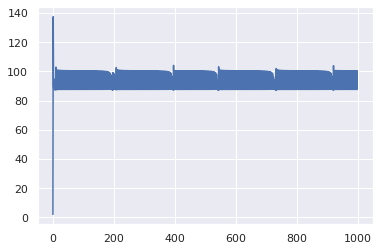

did not converge
13----------------------------------------------------
Index(['NES', 'NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NES_min', 'NOR_min',
       'NTE_min', 'OCC_min', 'ORI_min', 'PEN_min'],
      dtype='object')


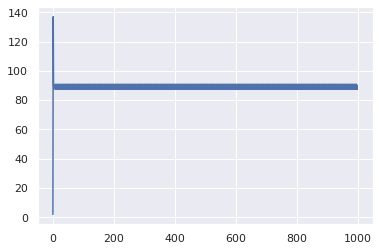

did not converge
12----------------------------------------------------
Index(['NES', 'NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NOR_min', 'NTE_min',
       'OCC_min', 'ORI_min', 'PEN_min'],
      dtype='object')


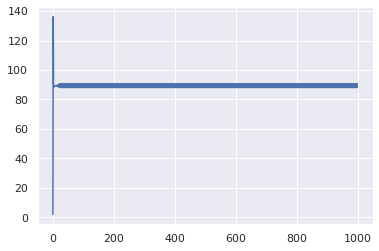

did not converge
11----------------------------------------------------
Index(['NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NOR_min', 'NTE_min', 'OCC_min',
       'ORI_min', 'PEN_min'],
      dtype='object')


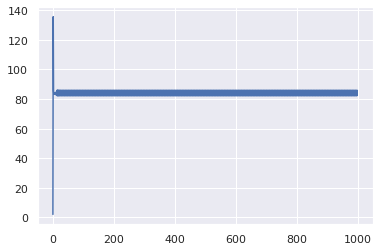

did not converge
10----------------------------------------------------
Index(['NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NOR_min', 'NTE_min', 'OCC_min',
       'PEN_min'],
      dtype='object')


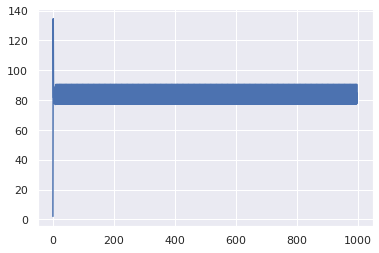

did not converge
9----------------------------------------------------
Index(['NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NTE_min', 'OCC_min', 'PEN_min'], dtype='object')


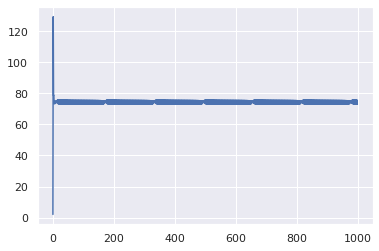

8----------------------------------------------------
Index(['NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NTE_min', 'PEN_min'], dtype='object')


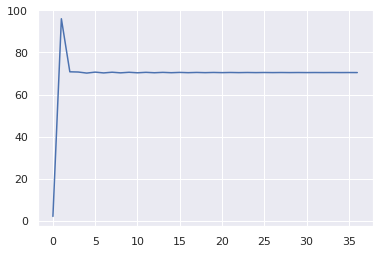

did not converge
7----------------------------------------------------
Index(['NOR', 'NTE', 'ORI', 'PEN', 'NTE_min', 'PEN_min'], dtype='object')


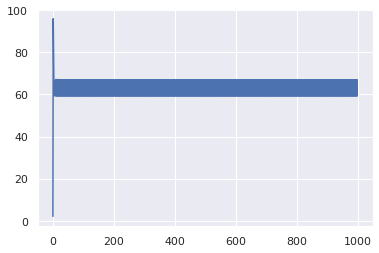

did not converge
6----------------------------------------------------
Index(['NOR', 'ORI', 'PEN', 'NTE_min', 'PEN_min'], dtype='object')


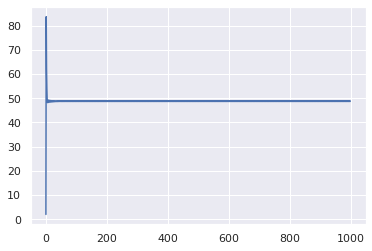

5----------------------------------------------------
Index(['NOR', 'PEN', 'NTE_min', 'PEN_min'], dtype='object')


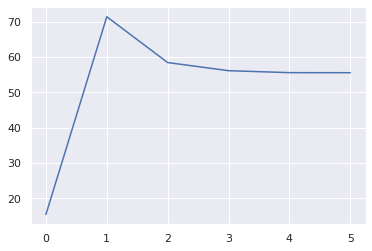

4----------------------------------------------------
Index(['NOR', 'PEN', 'PEN_min'], dtype='object')


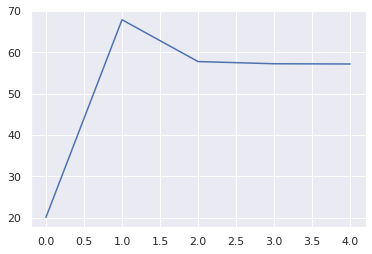

3----------------------------------------------------
Index(['NOR', 'PEN_min'], dtype='object')


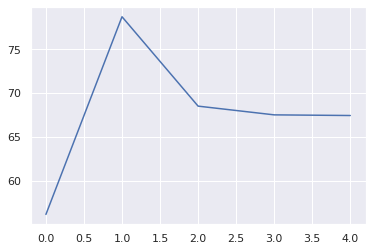

2----------------------------------------------------
Index(['PEN_min'], dtype='object')


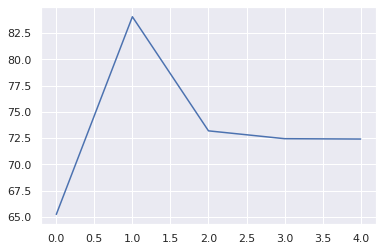

In [21]:
column  = X_train.columns
Flag = True

while(Flag == True):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        # Fit a GAM    
        gam = LogisticGAM(max_iter=1000, tol=0.001, verbose=True).fit(X_train[column], y_train)
        
        if len(column) >1 :
            print(str(len(column))+'----------------------------------------------------')
            
            ## DETECTAMOS EL FACTOR DE INFLACIÓN DE LA VARIANZA
            # VIF dataframe 
            vif = pd.DataFrame()
            vif["feature"] = X_train.columns
            # calculating VIF for each feature
            vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
            #vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.values.shape[1])]

            column = vif["VIF"]
            max_value = column.max()
            indx = vif[vif['VIF'] == max_value].index

            X_train.drop(X_train.columns[indx.values[0]], axis=1, inplace=True)
            column = X_train.columns
            print(column)
            _ = plt.plot(gam.logs_['deviance'])
            plt.show()
            
        else:
            Flag = False

In [22]:
X = df[['NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NTE_min', 'OCC_min', 'PEN_min']] ## Predictors
y = df['L3']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 5)
column = X_train.columns
print(column)

Index(['NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NTE_min', 'OCC_min', 'PEN_min'], dtype='object')


/usr/local/lib/python3.7/dist-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


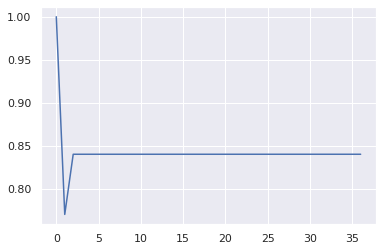

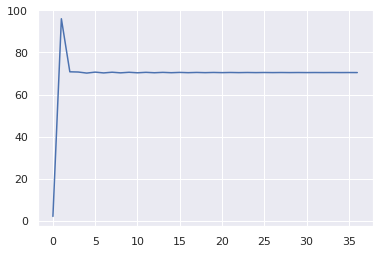

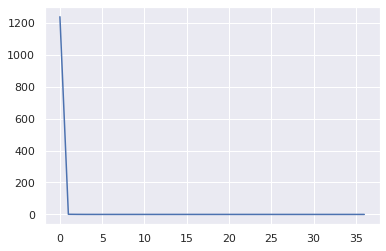

In [23]:
# Fit a GAM    
gam = LogisticGAM(max_iter=1000, tol=0.001, verbose=True).fit(X_train[column], y_train)
_ = plt.plot(gam.logs_['accuracy'])
plt.show()
_ = plt.plot(gam.logs_['deviance'])
plt.show()
_ = plt.plot(gam.logs_['diffs'])
plt.show()

In [24]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     11.1091
Link Function:                        LogitLink Log Likelihood:                                   -35.2326
Number of Samples:                          100 AIC:                                               92.6832
                                                AICc:                                               96.337
                                                UBRE:                                               3.0157
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4917
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [25]:
# Exactitud del modelo
print('Test accuracy GAM = ', accuracy_score(y_test, gam.predict(X_test[column])))
#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, gam.predict(X_test[column]))
print(confussion_matrix)

Test accuracy GAM =  0.7319148936170212
[[ 69  27]
 [ 36 103]]


<Figure size 432x288 with 0 Axes>

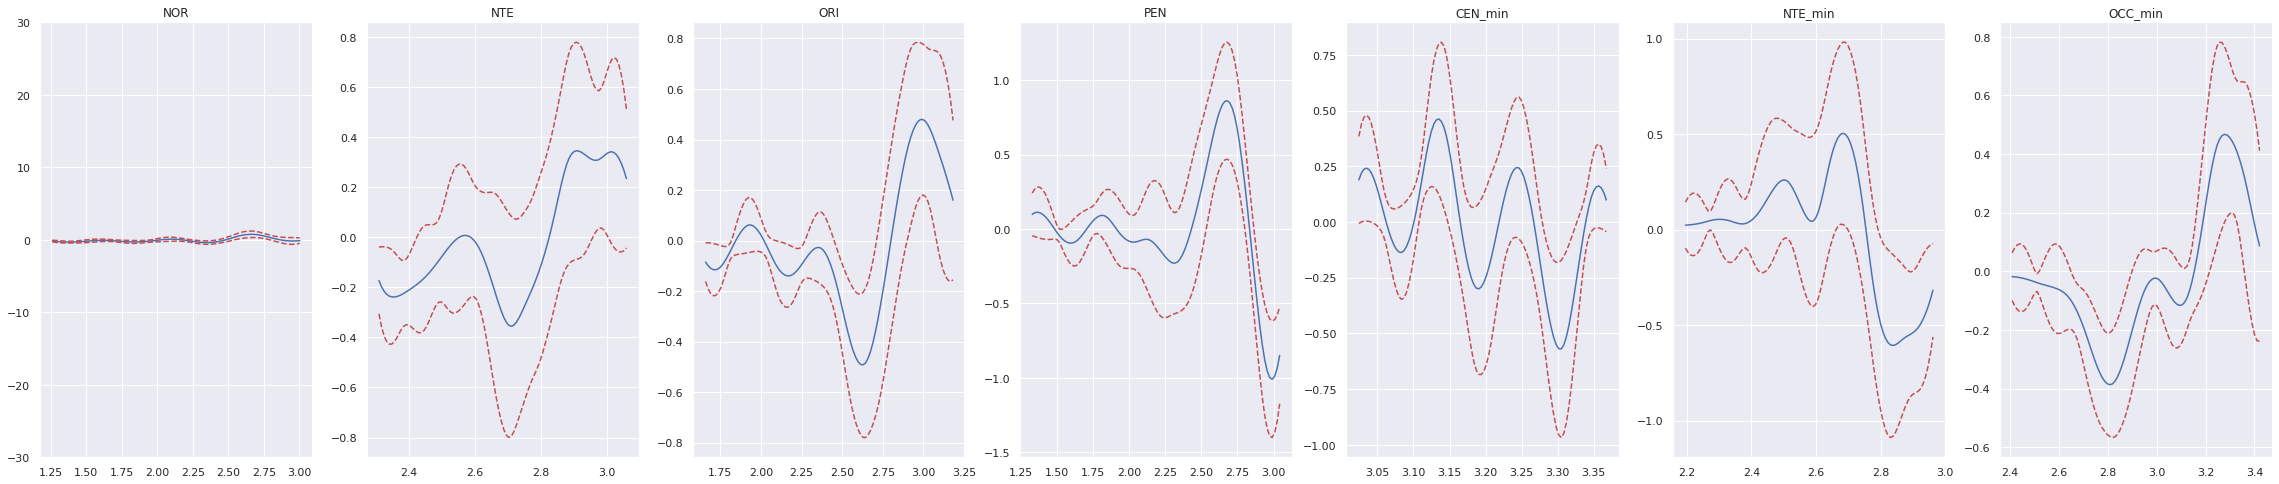

In [26]:
titles = X_test[column].columns[0:8]
plt.figure()
fig, axs = plt.subplots(1, 7, figsize=(40, 8))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])
        
plt.show()
plt.savefig('fig_t9_1.png')

## Best subset in GAM

In [27]:
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN','CEN_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEN_min']] ## Predictors
X = df[['NOR', 'NTE', 'ORI', 'PEN', 'CEN_min', 'NTE_min', 'OCC_min', 'PEN_min']] ## Predictors
y = df['L3']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 5)

In [28]:
## Loop over all possible numbers of features to be included
results = pd.DataFrame(columns=['num_features', 'features', 'accuracy'])
for k in range(1, X_train.shape[1] + 1):

    # Loop over all possible subsets of size k
    for subset in itertools.combinations(range(X_train.shape[1]), k):
        subset = list(subset)            
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            # Fit a GAM    
            gam = LogisticGAM(max_iter=1000, tol=0.001, verbose=True).fit(X_train.iloc[:, subset], y_train)         
        
            accuracy = accuracy_score(y_test, gam.predict(X_test.iloc[:, subset]))
            results = results.append(pd.DataFrame([{'num_features': k,
                                                    'features': subset,
                                                    'accuracy': accuracy}]))
print(results.sort_values('accuracy'))
subset_best = list(results.sort_values('accuracy')['features'].head(1)[0]) ## Seleccionamos el mejor subconjunto con mayor exactitud
gam.summary()

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
   num_features   features  accuracy
0             1        [1]  0.634043
0             2     [1, 4]  0.642553
0             1        [4]  0.655319
0             2     [0, 5]  0.672340
0             3  [0, 3, 5]  0.676596
..          ...        ...       ...
0             2     [1, 6]  0.825532
0             2     [4, 6]  0.825532
0             1        [6]  0.829787
0             2     [0, 6]  0.84255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



## Árboles de decisión

In [9]:
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN','CEN_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEN_min']] ## Predictors
y = df['L3']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 5)

## Poda de árbol de decisión usando cross-validation
En esta función se calcula un árbol para cada una de las una de las muestras `X_test` extraidas del total del conjunto de entrenamiento `X_train`. Los datos de error del muestreo cross-validation se guardan en la lista `cross_ols`.

In [ ]:
#Evaluación del desempeño del bootstrap variando tamaño de las muestra y número de muestreos aleatorios (repeticiones).
# evaluate a decision tree model using k-fold cross-validation
size =[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
test = []
accuracy = []

for i in size:
    cv = KFold(n_splits = 10, random_state = 1, shuffle = True)
    clf = tree.DecisionTreeClassifier(max_leaf_nodes = i,criterion = "entropy", random_state = 100,
                                  max_depth=100, min_samples_leaf=5)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    accuracy.append(mean(scores))

test.append(accuracy)


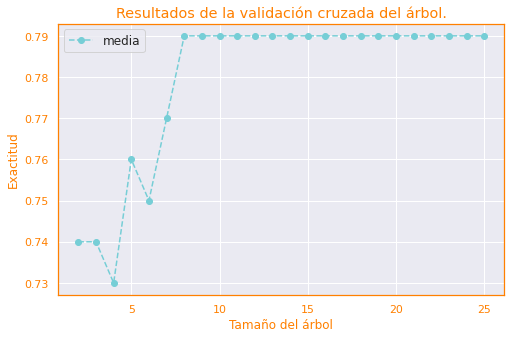

In [11]:
labels   = ['media',]
Xlabel   = 'Tamaño del árbol'
Ylabel   = 'Exactitud'
title    = "Resultados de la validación cruzada del árbol."
namefile = 'fig_t9_2'
dibuja_lineas(size, test, labels, namefile, Xlabel, Ylabel, title) 

In [16]:
size =[8]
for i in size:
    cv = KFold(n_splits = 10, random_state = 1, shuffle = True)
    clf = tree.DecisionTreeClassifier(max_leaf_nodes = 8,criterion = "entropy", random_state = 100,
                                  max_depth=100, min_samples_leaf=5)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    accuracy.append(mean(scores))

test.append(accuracy)

Accuracy: 0.790 (0.145)


In [18]:
clf = tree.DecisionTreeClassifier(max_leaf_nodes=8,criterion = "gini", random_state = 100,
                               max_depth=10, min_samples_leaf=5)
clf = clf.fit(X_train, y_train)
print('Test accuracy árbol = ', accuracy_score(y_test, clf.predict(X_test)))

#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, clf.predict(X_test))
print(confussion_matrix)

Test accuracy árbol =  0.7489361702127659
[[77 19]
 [40 99]]


In [21]:
dot_data = tree.export_graphviz(clf, out_file = None,
                                feature_names = X_test.columns.values.tolist(),
                                class_names = X_test.columns.values.tolist(),
                                filled = True, 
                                rounded = True, 
                                special_characters = True)  
graph = graphviz.Source(dot_data)  
graph.save('fig_t9_3.png')

'fig_t9_3.png'

### Poda del árbol usando la metodología propuesta por 

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

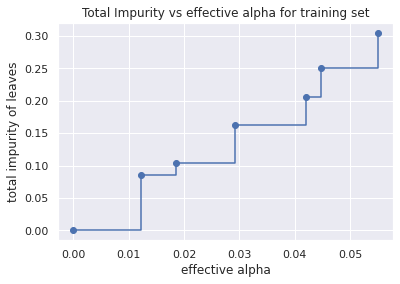

In [33]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [34]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1953125


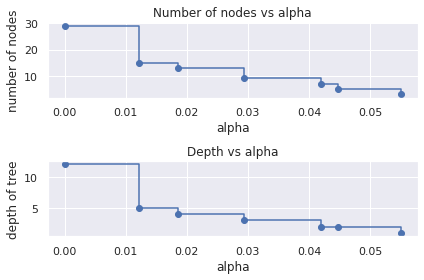

In [35]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


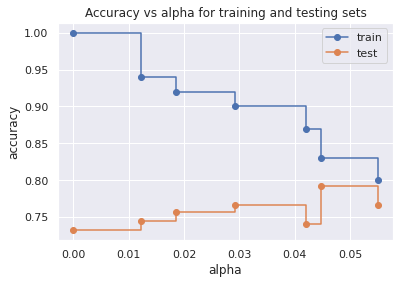

In [36]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()


[pyGAM Documentation, Daniel Servén,2018
](https://readthedocs.org/projects/pygam/downloads/pdf/stable/)

[Doc LogisticGAM](https://pygam.readthedocs.io/en/latest/api/logisticgam.html)

[A Tour of pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html)

[A example of pyGAM](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[documentación pyGAM](https://pygam.readthedocs.io/en/latest/)

[pyGAM : Getting Started with Generalized Additive Models in Python](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[Building interpretable models with Generalized additive models in Python](https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515)

[Scikit Decision Trees](https://scikit-learn.org/stable/modules/tree.html)

[Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)

[Understanding the decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)

[Understanding Decision Tree Classification with Scikit-Learn](https://towardsdatascience.com/decision-tree-classifier-and-cost-computation-pruning-using-python-b93a0985ea77)

[Decision Tree Classifier and Cost Computation Pruning using Python](https://towardsdatascience.com/decision-tree-classifier-and-cost-computation-pruning-using-python-b93a0985ea77)

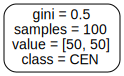

In [37]:
#tree.plot_tree(clf)
#plt.show()
#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("overload") 

dot_data = tree.export_graphviz(clf, out_file = None,
                                feature_names = X_test.columns.values.tolist(),
                                class_names = X_test.columns.values.tolist(),
                                filled = True, 
                                rounded = True, 
                                special_characters = True)  
graph = graphviz.Source(dot_data)  
graph 